# DETECCIÓN DE MODELOS DE AVIONES MILITARES SEGUIDO DE UN ATAQUE FGSM GENÉRICO Y DIRIGIDO

El objetivo de esta práctica es entrenar un modelo capaz de clasificar los diferentes aviones militares de este dataset (https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset) para a continuación a partir de un ataque FGSM genérico y dirigido, tratando en este último de forzar la clasificación hacia un conjunto de clases seleccionadas.


### CONFIGURACIÓN DEL ENTORNO

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Apr 14 18:16:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Descarga del dataset

path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")
print(f"Dataset guardado en {path}")

100%|██████████| 9.94G/9.94G [05:14<00:00, 33.9MB/s]

Extracting files...


Dataset guardado en /root/.cache/kagglehub/datasets/a2015003713/militaryaircraftdetectiondataset/versions/87


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PRIMERA PARTE. CARGA Y ANÁLISIS DEL DATASET

In [ ]:
# En el dataset no viene el país de origen de los modelos, por tanto se añade posteriormente

model_by_country = {
    'EE. UU.': [
        'F18', 'B1', 'C130', 'U2', 'V280', 'AV8B', 'C17', 'A10', 'RQ4',
        'UH60', 'MQ9', 'B52', 'F15', 'YF23', 'F117', 'F22', 'C5', 'CH47',
        'C2', 'E2', 'US2', 'P3', 'XB70', 'F35', 'F16', 'F14', 'B21', 'KC135',
        'AH64', 'F4', 'B2', 'V22', 'SR71'
    ],

    'Rusia': [
        'Su25', 'KJ600', 'Su57', 'Mi26', 'Tu160', 'Ka52', 'An72', 'Mi24',
        'An124', 'Il76', 'Mig31', 'Tu22M', 'Mi28', 'Mi8', 'Su34', 'Su24',
        'Tu95', 'Mig29', 'Ka27', 'An225', 'An22'
    ],

    'China': [
        'J10', 'WZ7', 'Z19', 'Z10', 'Y20', 'J20', 'H6', 'JH7', 'AG600',
        'TB001', 'TB2', 'WZ7', 'J35'
    ],

    'OTAN': [
        'EF2000', 'Tornado', 'A400M', 'Rafale', 'JAS39', 'Mirage2000',
        'Vulcan', 'KAAN', 'C390', 'Be200'
    ],

    'Canada': [
        'CL415'
    ],

    'Brasil': [
        'EMB314', 'E7'
    ],

    'Japón': [
        'KF21', 'US2'
    ],

    'Pakistán': [
        'JF17'
    ]
}

model_to_country = {}
for country, models in model_by_country.items():
    for model in models:
        model_to_country[model] = country

In [ ]:
# Leer el contenido del dataset y construir el dataframe

main_dir = os.path.join(path,"crop")
train_image_path = []
train_labels = []
total_images = 0

for folder in os.listdir(main_dir):
    folder_path = os.path.join(main_dir,folder)
    total_images += len(os.listdir(folder_path))

    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path,image)
        train_image_path.append(image_path)
        train_labels.append(folder)

df = pd.DataFrame(data={'file_path':train_image_path,'label':train_labels})
df['country'] = df['label'].apply(lambda x: model_to_country.get(x))

print(f"Hay un total de {len(os.listdir(main_dir))} modelos diferentes, {total_images} imágenes y {len(model_by_country)} paises de orígen diferentes.")

Hay un total de 83 modelos diferentes, 35410 imágenes y 8 paises de orígen diferentes.


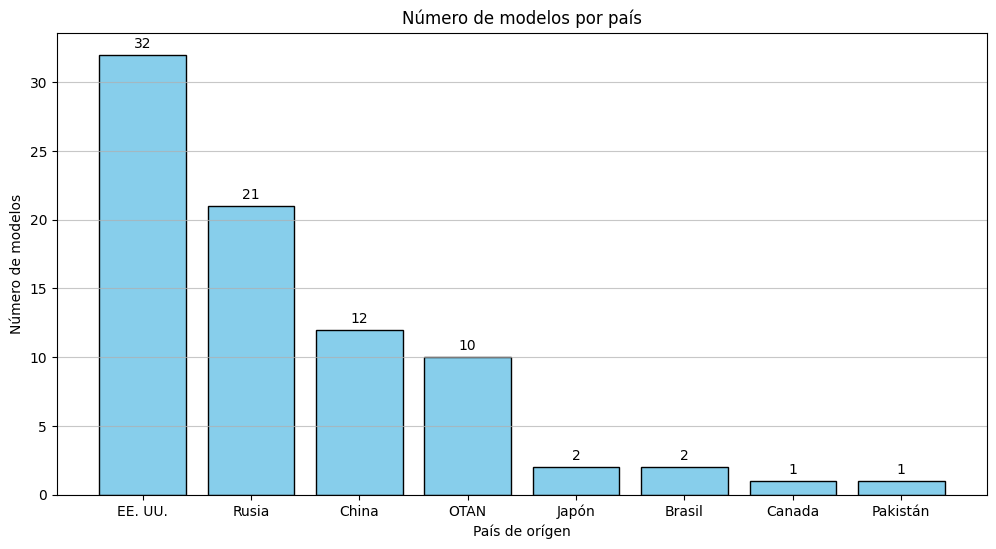

In [ ]:
# Mostrar el número de modelos por país

model_counts_by_country = df.groupby('country')['label'].nunique()
model_counts_by_country = model_counts_by_country.sort_values(ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(model_counts_by_country.index, model_counts_by_country.values, color='skyblue', edgecolor='black')
plt.bar_label(bars, padding=3)
plt.title('Número de modelos por país')
plt.xlabel('País de orígen')
plt.ylabel('Número de modelos')
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.show()

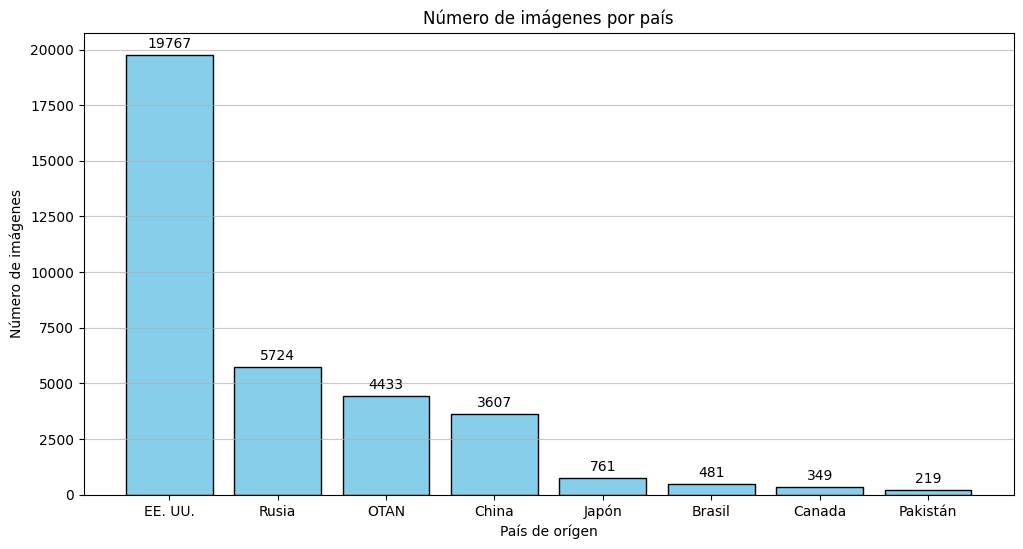

In [ ]:
# Mostrar el número de imágenes por país

country_counts = df['country'].value_counts()
country_counts = country_counts.sort_values(ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(country_counts.index, country_counts.values, color='skyblue', edgecolor='black')
plt.bar_label(bars, padding=3)
plt.title('Número de imágenes por país')
plt.xlabel('País de orígen')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.show()

In [ ]:
# Mostrar el número de imágenes por modelo de avión y por país

model_counts = df["label"].value_counts()

model_counts = model_counts.to_frame().reset_index()
model_counts.columns = ['label', 'count']
model_counts['country'] = model_counts['label'].map(model_to_country)

countries = sorted(model_counts['country'].unique())
num_countries = len(countries)
colors = plt.cm.get_cmap('gnuplot_r', num_countries)

plt.figure(figsize=(20, 7))
plt.xlabel("Modelo")
plt.ylabel("Número de imágenes")
plt.title("Número de imágenes por modelo")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="-", alpha=0.7)

handles = []
labels = []
for i, country in enumerate(countries):
    handles.append(plt.Rectangle((0, 0), 1, 1, color=colors(i)))
    labels.append(country)

plt.legend(handles, labels, title="País de orígen")

for i, (country, group) in enumerate(model_counts.groupby('country')):
    bar = plt.bar(group['label'], group['count'], color=colors(i), label=country)
    plt.bar_label(bar, padding=3, rotation=90)

plt.tight_layout()
plt.show()

TypeError: '<' not supported between instances of 'float' and 'str'

## SEGUNDA PARTE. ENTRENAMIENTO DEL MODELO

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir en conjunto de entrenamiento (70%) y prueba (30%)
train_df, test_df = train_test_split(df,
                                     test_size = 0.3,
                                     stratify = df['label'],
                                     random_state = 42
                                     )

# Dividir el conjunto de prueba en validación (15%) y prueba (15%)
test_df, val_df = train_test_split(test_df,
                                     test_size = 0.5,
                                     stratify = test_df['label'],
                                     random_state = 42
                                   )

# train_df: 70% de los datos para entrenamiento
# val_df: 15% de los datos para validación
# test_df: 15% de los datos para prueba

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 1
img_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col= 'file_path',
    y_col= 'label',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

valid_gen = gen.flow_from_dataframe(
    val_df,
    x_col= 'file_path',
    y_col= 'label',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= False,
    batch_size= batch_size
)

test_gen = gen.flow_from_dataframe(
    test_df,
    x_col= 'file_path',
    y_col= 'label',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= False,
    batch_size= batch_size
)

In [ ]:
# Mostrar 20 imágenes de 20 clases aleatorias

g_dict = train_gen.class_indices
classes = list(g_dict.keys())
num_classes = len(classes)
random_classes = random.sample(classes, 20)
displayed_classes = set()

plt.figure(figsize=(20, 20))

for i, class_name in enumerate(random_classes):
    if class_name in displayed_classes:
        continue

    for j in range(len(train_gen)):
        images, labels = next(train_gen)
        for k in range(images.shape[0]):
            index = np.argmax(labels[k])
            if classes[index] == class_name:
                plt.subplot(4, 5, i + 1)
                image = images[k] / 255
                plt.imshow(image)
                plt.title(class_name, color='black', fontsize=14)
                plt.axis('off')
                displayed_classes.add(class_name)
                break
        else:
            continue
        break

plt.show()

In [ ]:
# Carga del modelo entrenado

from tensorflow import keras

model_path = '/content/drive/MyDrive/20250330_efficientnet.keras'
model = keras.models.load_model(model_path)

In [ ]:
# DESCOMENTAR ESTA CELDA Y COMENTAR LA ANTERIOR PARA ENTRENAR EL MODELO

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras import regularizers

# num_epochs = 25

# channels = 3
# img_shape = (img_size[0], img_size[1], channels)
# class_count = len(list(train_gen.class_indices.keys()))

# base_model = EfficientNetB3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=img_shape,
#     pooling="max"
# )

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.5),
#     Dense(class_count, activation="softmax")
# ])

# model.compile(
#     Adamax(learning_rate= 0.0001),
#     loss= 'categorical_crossentropy',
#     metrics= ['accuracy']
# )

# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=3,
#     min_lr=1e-6,
#     verbose=1
# )

# history = model.fit(
#     train_gen,
#     epochs=num_epochs,
#     validation_data=valid_gen,
#     batch_size=batch_size,
#     callbacks=[early_stopping, reduce_lr]
# )

# import datetime

# current_datetime = datetime.datetime.now()
# day_string = current_datetime.strftime("%Y%m%d")
# model_save_path = f'/content/drive/MyDrive/{day_string}_efficientnet.keras'
# model.save(model_save_path)
# print(f'Path: {day_string}.h5')

# tr_acc = history.history['accuracy']
# tr_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# index_loss = np.argmin(val_loss)
# val_lowest = val_loss[index_loss]
# index_acc = np.argmax(val_acc)
# acc_highest = val_acc[index_acc]

# Epochs = [i+1 for i in range(len(tr_acc))]
# loss_label = f'best epoch= {str(index_loss + 1)}'
# acc_label = f'best epoch= {str(index_acc + 1)}'

# # Plot training history
# plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

# plt.subplot(1, 2, 1)
# plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
# plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
# plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout
# plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_gen)
print('Test accuracy:', accuracy)
print('Test loss:', loss)

In [ ]:
predictions = model.predict(test_gen)

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_gen[i // batch_size][0][i % batch_size] / 255.0, cmap=plt.cm.binary)
    predicted_label = class_names[predicted_labels[i]]
    true_label = class_names[true_labels[i]]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"Predicho: {predicted_label}\nVerdad: {true_label}", color=color)
plt.show()

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

plt.figure(figsize=(30, 25))
cm = confusion_matrix(test_gen.classes, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [ ]:
report = classification_report(test_gen.classes, predicted_labels, target_names= classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df[~report_df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]
report_df = report_df.sort_values(by=['support'], ascending=False)

country_colors = {
    'EE. UU.': 'blue',
    'Rusia': 'red',
    'China': 'green',
    'OTAN': 'orange',
    'Canada': 'purple',
    'Brasil': 'brown',
    'Japón': 'pink',
    'Pakistán': 'gray'
}

report_df = report_df.reset_index()
report_df = report_df.rename(columns={"index": "model"})
report_df['country'] = report_df['model'].apply(lambda x: model_to_country.get(x))

for metric in ['precision', 'recall', 'f1-score', 'support']:
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.suptitle(f'{metric.capitalize()} por modelo y país', fontsize=16)
    report_df = report_df.sort_values(by=['country', 'model'])

    sns.barplot(ax=ax, x='model', y=metric, hue='country', data=report_df, dodge=False, palette=country_colors)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metric.capitalize())
    ax.legend(title="Países")
    plt.tight_layout()
    plt.show()

## TERCERA PARTE. ATAQUE FGSM GENÉRICO

In [ ]:
use_cuda = True

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print(f"Using device: {device}")

In [ ]:
def fgsm_attack(model, image, label, epsilon):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image, training=False)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 255.0)

    return adversarial_image

In [ ]:
from tqdm.notebook import tqdm

def test_fgsm_attack(model, test_gen, epsilon, max_samples):
    adv_images = []
    orig_preds = []
    adv_preds = []
    count = 0
    correct = 0

    with tqdm(total=max_samples, desc="Realizando ataque") as pbar:
        for image, label in test_gen:
            if count >= max_samples:
                break

            orig_pred = model(image)
            orig_label = np.argmax(orig_pred)
            real_label = np.argmax(label)

            if orig_label != real_label:
                continue

            pbar.update(1)
            adv_img = fgsm_attack(model, image, label, epsilon)
            adv_pred = model(adv_img)
            adv_label = np.argmax(adv_pred)

            if adv_label == orig_label:
                correct += 1

            adv_images.append(adv_img)
            adv_preds.append(adv_label)
            orig_preds.append(orig_label)
            count += 1

    final_acc = (correct/count)*100
    print("Fase Terminada con Epsilon: {}\tPrecision en conjunto Test = {}%".format(epsilon, final_acc))

    return final_acc, adv_images, adv_preds, orig_preds

In [ ]:
epsilon = [0, 0.01, 0.05, 0.10, 0.20, 0.50, 1, 5, 10, 50]
images_per_eps = 30

In [ ]:
acc = []
adv_images = []
orig_preds = []
adv_preds = []

with tqdm(total=len(epsilon), desc="Progreso total") as pbar:
    for eps in epsilon:
        pbar.update(1)
        final_acc, adv_images_per_eps, adv_preds_per_eps, orig_preds_per_eps = test_fgsm_attack(model, test_gen, eps, images_per_eps)
        acc.append(final_acc)
        adv_images.append(adv_images_per_eps)
        adv_preds.append(adv_preds_per_eps)
        orig_preds.append(orig_preds_per_eps)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epsilon, acc, marker='o', linestyle='-')
plt.title('Precisión vs Epsilon en ataque FGSM')
plt.xlabel('Epsilon')
plt.ylabel('Precisión (%)')
plt.grid(True)
plt.show()

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

num_images = 10

for eps in range(len(epsilon)):
  plt.figure(figsize=(25, 25))
  for i in range(num_images):
      plt.subplot(len(epsilon), num_images, i + 1)
      plt.imshow(adv_images[eps][i][0] / 255.0)

      predicted_model = classes[orig_preds[eps][i]]
      attack_model = classes[adv_preds[eps][i]]

      if predicted_model != attack_model:
          color = 'green'
      else:
          color = 'red'

      title = f"Predicho: {predicted_model}\nAtaque: {attack_model}"
      plt.title(title, fontsize=12, color=color)
      plt.axis('off')

  plt.text(-11, 0.5, f"Epsilon: {round(epsilon[eps],2)}", fontsize=15, ha='center', va='center', rotation='vertical', transform=plt.gca().transAxes)
  plt.show()

# CUARTA PARTE. ATAQUE FGSM DIRIGIDO

In [ ]:
model_path = '/content/drive/MyDrive/20250330_efficientnet.keras'
model = keras.models.load_model(model_path)

In [ ]:
def fgsm_targeted_attack_adaptive(models, model, image, label, original_prediction, initial_epsilon, target_classes,
                                  iterations=50, min_epsilon=0.001, max_epsilon=10,
                                  confidence_threshold=0.9, verbose=True, early_stopping=True,
                                  adaptation_rate=0.1):

    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    original_class = np.argmax(original_prediction.numpy(), axis=1)

    if verbose:
        print(f"Original class: {models[original_class[0]]} ({original_class[0]}), Original confidence: {np.max(original_prediction.numpy(), axis=1)}")

    pred_values = original_prediction.numpy()
    target_probs = {cls: pred_values[0][cls] for cls in target_classes}
    most_prob_target_class = max(target_probs, key=target_probs.get)

    target_one_hot = tf.one_hot(most_prob_target_class, depth=label.shape[-1])

    best_results = {
        'image': None,
        'predicted_class': None,
        'epsilon': None,
        'confidence': -1,
        'success': False
    }

    current_epsilon = initial_epsilon
    prev_confidence = 0

    iterator = tqdm(range(iterations)) if verbose else range(iterations)

    epsilon_history = []
    confidence_history = []

    for i in iterator:
        perturbed_image = tf.Variable(image)

        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            prediction = model(perturbed_image, training=False)
            target_loss = -tf.reduce_sum(target_one_hot * tf.nn.log_softmax(prediction))

        gradient = tape.gradient(target_loss, perturbed_image)
        signed_grad = tf.sign(gradient)

        adversarial_image = tf.clip_by_value(perturbed_image - current_epsilon * signed_grad, 0, 255.0)

        new_prediction = model(adversarial_image, training=False)
        predicted_class = np.argmax(new_prediction.numpy(), axis=1)
        max_confidence = np.max(new_prediction.numpy(), axis=1)
        confidence = new_prediction.numpy()[0][most_prob_target_class]

        if predicted_class in target_classes:
            if confidence > best_results['confidence']:
                best_results['image'] = adversarial_image
                best_results['predicted_class'] = predicted_class
                best_results['epsilon'] = current_epsilon
                best_results['confidence'] = confidence
                best_results['success'] = True

        epsilon_history.append(current_epsilon)
        confidence_history.append(confidence)

        if i > 0:
            confidence_change = confidence - prev_confidence
            if confidence_change > 0:
                if len(epsilon_history) >= 3:
                    epsilon_direction = epsilon_history[-1] - epsilon_history[-2]
                    direction_sign = 1 if epsilon_direction > 0 else -1
                    step_size = abs(epsilon_direction) * (1 + confidence_change * 2)
                    next_epsilon = current_epsilon + direction_sign * step_size
                else:
                    next_epsilon = current_epsilon * (1 + adaptation_rate)
            else:
                if len(epsilon_history) >= 3:
                    epsilon_direction = epsilon_history[-1] - epsilon_history[-2]
                    next_epsilon = current_epsilon - epsilon_direction * adaptation_rate
                else:
                    next_epsilon = current_epsilon * (1 - adaptation_rate)
        else:
            next_epsilon = current_epsilon * (1 + adaptation_rate)

        next_epsilon = np.clip(next_epsilon, min_epsilon, max_epsilon)

        if verbose:
            iterator.set_description(f"Epsilon: {current_epsilon}, "
                                    f"Max Confidence: {max_confidence}, Target Confidence: {confidence}")

        prev_confidence = confidence
        current_epsilon = next_epsilon

        if early_stopping and best_results['confidence'] > confidence_threshold:
            if verbose:
                print(f"\nEarly stopping at iteration {i+1}/{iterations}. "
                      f"Achieved {best_results['confidence']} confidence in target class {models[best_results['predicted_class'][0]]} ({best_results['predicted_class'][0]})")
            break

    if i == iterations - 1 and epsilon_history:
        best_epsilon_idx = np.argmax(confidence_history)
        best_epsilon = epsilon_history[best_epsilon_idx]

        with tf.GradientTape() as tape:
            perturbed_image = tf.Variable(image)
            tape.watch(perturbed_image)
            prediction = model(perturbed_image, training=False)
            target_loss = -tf.reduce_sum(target_one_hot * tf.nn.log_softmax(prediction))

        gradient = tape.gradient(target_loss, perturbed_image)
        signed_grad = tf.sign(gradient)
        final_adversarial_image = tf.clip_by_value(perturbed_image - best_epsilon * signed_grad, 0, 255.0)

        final_prediction = model(final_adversarial_image, training=False)
        final_class = np.argmax(final_prediction.numpy(), axis=1)
        final_confidence = np.max(final_prediction.numpy(), axis=1)

        if final_class in target_classes and final_confidence > best_results['confidence']:
            best_results['image'] = final_adversarial_image
            best_results['predicted_class'] = final_class
            best_results['epsilon'] = best_epsilon
            best_results['confidence'] = final_confidence
            best_results['success'] = True

    if best_results['success']:
        if verbose:
            print(f"\nAttack successful! Target class: {models[best_results['predicted_class'][0]]} ({best_results['predicted_class'][0]}), "
                  f"Confidence: {best_results['confidence']}, Epsilon: {best_results['epsilon']}")
        return (best_results['image'], best_results['predicted_class'],
                best_results['epsilon'], True, best_results['confidence'])
    else:
        if verbose:
            print("\nAttack failed. Returning last attempt.")
        return (adversarial_image, predicted_class, current_epsilon, False, confidence)

In [ ]:
from tqdm.notebook import tqdm

def test_targeted_fgsm_attack(model, test_gen, epsilon, target_class, max_samples):
    adv_images = []
    adv_preds = []
    epsilons = []
    success = []
    confidence_list = []
    original_labels = []
    models = list(test_gen.class_indices.keys())
    count = 0

    with tqdm(total=max_samples, desc="Progreso") as pbar:
        for image, label in test_gen:
            pbar.update(1)

            if count >= max_samples:
                break

            if np.argmax(label) in target_class:
                continue

            orig_pred = model(image, training=False)
            orig_label = np.argmax(orig_pred)
            real_label = np.argmax(label)

            if orig_label != real_label:
                continue

            adversarial_image, predicted_class, current_epsilon, status, confidence = fgsm_targeted_attack_adaptive(models, model, image, label, orig_pred, epsilon, target_class)
            adv_images.append(adversarial_image)
            adv_preds.append(predicted_class)
            epsilons.append(current_epsilon)
            success.append(status)
            confidence_list.append(confidence)
            original_labels.append(real_label)

            count += 1

    return adv_images, adv_preds, epsilons, success, confidence_list, original_labels

In [ ]:
country = 'EE. UU.'

models = [k for k, v in model_to_country.items() if v == country]
target_classes = [test_gen.class_indices[model] for model in models]

epsilon = 0.5
max_samples = 100

print(f"Target classes are {target_classes}")
adv_images, adv_preds, epsilons, success, confidence_list, original_labels = test_targeted_fgsm_attack(model, test_gen, epsilon, target_classes, max_samples)

In [ ]:
success_count = sum(success)
failure_count = len(success) - success_count

labels = ['ÉXITO', 'FRACASO']

sizes = [success_count, failure_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title(f'Tasa de éxito del ataque FGSM dirigido ({max_samples} imágenes, 50 iteraciones)')
plt.show()

In [ ]:
successful_epsilons = [eps for eps, succ in zip(epsilons, success) if succ]
average_epsilon = np.mean(successful_epsilons)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(successful_epsilons)), successful_epsilons, marker='o', linestyle='-')
plt.axhline(y=average_epsilon, color='r', linestyle='--', label=f'Media: {average_epsilon:.2f}')
plt.title('Valores de Epsilon en Ataques FGSM Dirigidos Exitosos')
plt.xlabel('Índice de la Imagen')
plt.ylabel('Epsilon')

ymin = np.floor(min(successful_epsilons) / 0.5) * 0.5
ymax = np.ceil(max(successful_epsilons) / 0.5) * 0.5
plt.ylim(ymin, ymax)
plt.yticks(np.arange(ymin, ymax + 0.5, 0.5))

plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
successful_confidences = [conf for conf, succ in zip(confidence_list, success) if succ]
successful_confidences = [np.array([conf]) if np.isscalar(conf) else conf for conf in successful_confidences]

average_confidence = np.mean(successful_confidences)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(successful_confidences)), successful_confidences, marker='o', linestyle='-')
plt.axhline(y=average_confidence, color='r', linestyle='--', label=f'Media: {average_confidence:.2f}')
plt.title('Confianza en Ataques FGSM Dirigidos Exitosos')
plt.xlabel('Índice de la Imagen')
plt.ylabel('Confianza')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
class_names = list(test_gen.class_indices.keys())

successful_indices = [i for i, succ in enumerate(success) if succ]
successful_images = [adv_images[i] for i in successful_indices]
successful_preds = [adv_preds[i] for i in successful_indices]
successful_epsilons = [epsilons[i] for i in successful_indices]
successful_confidences = [confidence_list[i] for i in successful_indices]
successful_labels = [original_labels[i] for i in successful_indices]

num_images = 25

plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(successful_images[i][0].numpy() / 255.0)
    predicted_class = class_names[successful_preds[i][0]]
    epsilon_value = successful_epsilons[i]
    confidence_value = successful_confidences[i]
    original_label = class_names[successful_labels[i]]
    plt.title(f"{original_label} -> {predicted_class}\nEpsilon: {epsilon_value:.2f}, Confidence: {confidence_value:.2f}")
    plt.axis('off')
plt.show()